In [3]:
import torch
import corner
import numpy as np
import pylab as plt
from swyft.intensity import BallMask, ComboMask, Prior1d, Prior, Intensity
from tqdm import tqdm
import swyft
import swyft.plot

DEVICE = 'cuda'

%load_ext autoreload
%autoreload 2

In [4]:
def model(par):
    return dict(spec=np.linspace(-5, 5, 5)*par['A']+par['B'])

def noise(obs, par):
    obs['spec'] += np.random.randn(*obs['spec'].shape)*1.
    return obs

In [5]:
class Hooft(swyft.Module):
    def __init__(self, obs_shapes, factor = 1.):
        super().__init__(factor = factor)
        self.factor = factor
    
    def forward(self, x):
        return x['spec']

### Storage

In [6]:
cache = swyft.MemoryCache(params = ["A", "B"], obs_shapes = {"spec": (5,)})
#cache = swyft.DirectoryCache(params = ["A", "B"], obs_shapes = {"spec": (5,)}, path = "/home/weniger/zarr_test4")

Creating new cache.


In [7]:
prior = Prior({"A": ["normal", 0., 1.], "B": ["normal",  0., 1.]})

### Populating storage with simulations

In [16]:
N = 1000
cache.grow(prior, N)
cache.simulate(model)

No new simulator runs required.
No simulations required.


In [17]:
points = swyft.Points(cache.sample(prior, N), cache, noise)

In [13]:
re = swyft.RatioEstimator(["A", "B", ("A", "B")], device=DEVICE, tail_args=dict(n_tail_features = 2, n_hidden=64, p = 0.1))
re.train(points, batch_size = 8, lr_schedule = [1e-3])

n_features = 5
Start training
LR iteration 0
Validation loss: 3.3068259159723916
Validation loss: 2.237502634525299
Validation loss: 1.9349097559849422
Validation loss: 1.931132232149442
Validation loss: 2.034402683377266
Total epochs: 5


In [14]:
i = 1
obs0, par0 = points[i]['obs'], points[i]['par']
post = re.posterior(obs0, prior, n_samples = 100000)

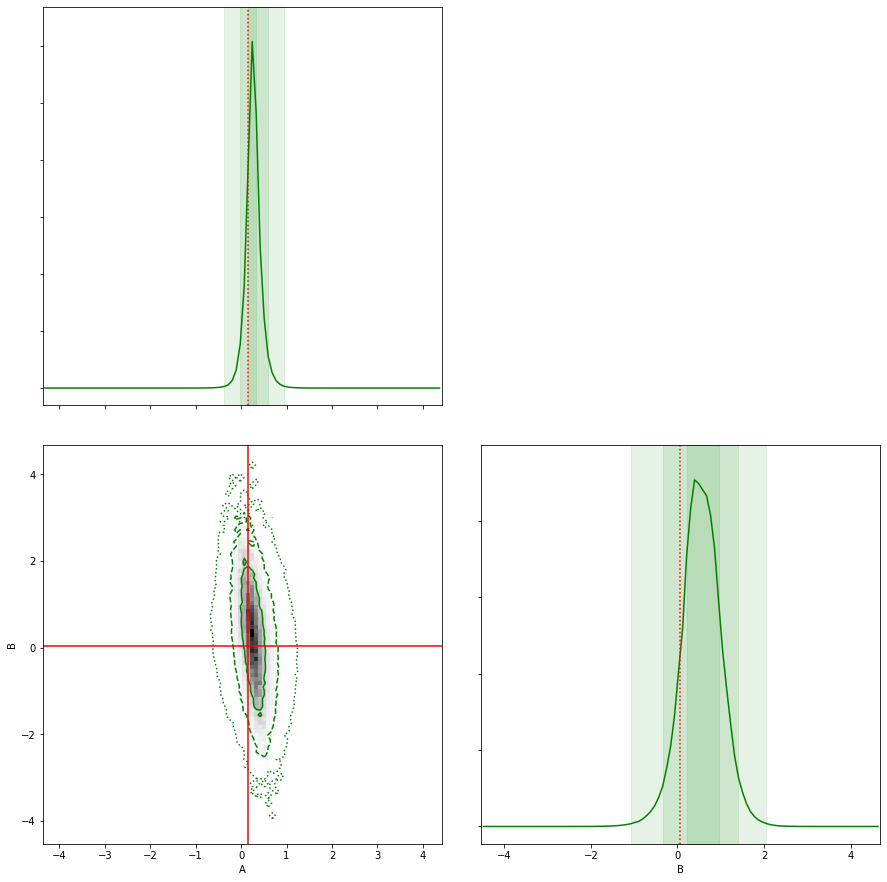

In [15]:
swyft.plot.corner(post, ["A", "B"], color='g', figsize = (15,15), truth=par0)

In [30]:
prior2 = prior.get_masked(obs0, re, th = -10)

In [31]:
cache.grow(prior2, 2000)
cache.simulate(model)

No new simulator runs required.
No simulations required.


In [32]:
indices = cache.sample(prior2, 2000)
points = swyft.Points(indices, cache, noise)

In [33]:
re2 = swyft.RatioEstimator([("A",), ("B",), ("A", "B")], device=DEVICE, tail_args = dict(p=0.1))
re2.train(points, max_epochs=10, batch_size=16, lr_schedule=[1e-3, 1e-4])

n_features = 5
Start training
LR iteration 0
Validation loss: 3.877273201942444
Validation loss: 2.4512495001157126
Validation loss: 2.094765971104304
Validation loss: 2.0673781832059226
Validation loss: 2.033286859591802
Validation loss: 2.0987727642059326
Total epochs: 6
LR iteration 1
Validation loss: 2.0178744395573935
Validation loss: 1.9989164074261982
Validation loss: 2.1065600514411926
Total epochs: 3


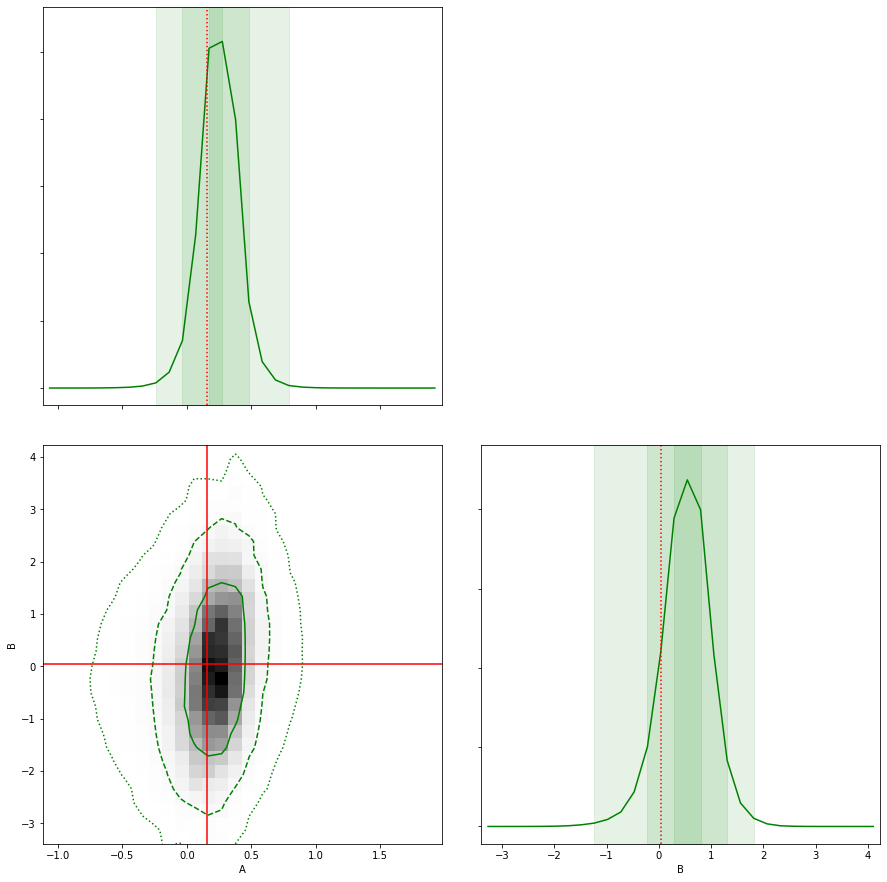

In [37]:
post2 = re2.posterior(obs0, prior2, n_samples = 100000)
swyft.plot.corner(post2, ["A", "B"], color='g', figsize = (15,15), truth=par0, bins = 30)